In [1]:
!pip3 install pandas
!pip3 install seaborn
!pip3 install --upgrade tensorflow-gpu
!pip3 install import-ipynb

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import pickle
import time
import sys

import import_ipynb
import VariationalAutoencoderModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
importing Jupyter notebook from VariationalAutoencoderModel.ipynb
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

# Simple Home 1003 Camera Data Pre-Processing

In [3]:
# Benign traffic

s3_benign = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_s3_benign = s3_benign.copy(deep=True)

columns = list(df_s3_benign.columns)
chosen_columns = []
for column in columns:
    if column.find('L5') != -1:
        chosen_columns.append(column)
        
df_s3_benign = pd.DataFrame(df_s3_benign, columns = chosen_columns)

# Mirai

s3_mirai_ack = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai/ack.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_ack = s3_mirai_ack.copy(deep=True)
df_s3_mirai_ack = pd.DataFrame(df_s3_mirai_ack, columns = chosen_columns)

s3_mirai_scan = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_scan = s3_mirai_scan.copy(deep=True)
df_s3_mirai_scan = pd.DataFrame(df_s3_mirai_scan, columns = chosen_columns)

s3_mirai_syn = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai/syn.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_syn = s3_mirai_syn.copy(deep=True)
df_s3_mirai_syn = pd.DataFrame(df_s3_mirai_syn, columns = chosen_columns)

s3_mirai_udp = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_udp = s3_mirai_udp.copy(deep=True)
df_s3_mirai_udp = pd.DataFrame(df_s3_mirai_udp, columns = chosen_columns)

s3_mirai_udpplain = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_udpplain = s3_mirai_udpplain.copy(deep=True)
df_s3_mirai_udpplain = pd.DataFrame(df_s3_mirai_udpplain, columns = chosen_columns)

# Bashlite

s3_bashlite_combo = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt/combo.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_combo = s3_bashlite_combo.copy(deep=True)
df_s3_bashlite_combo = pd.DataFrame(df_s3_bashlite_combo, columns = chosen_columns)

s3_bashlite_junk = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt/junk.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_junk = s3_bashlite_junk.copy(deep=True)
df_s3_bashlite_junk = pd.DataFrame(df_s3_bashlite_junk, columns = chosen_columns)

s3_bashlite_scan = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_scan = s3_bashlite_scan.copy(deep=True)
df_s3_bashlite_scan = pd.DataFrame(df_s3_bashlite_scan, columns = chosen_columns)

s3_bashlite_udp = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_udp = s3_bashlite_udp.copy(deep=True)
df_s3_bashlite_udp = pd.DataFrame(df_s3_bashlite_udp, columns = chosen_columns)

s3_bashlite_tcp = pd.read_csv('nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_tcp = s3_bashlite_tcp.copy(deep=True)
df_s3_bashlite_tcp = pd.DataFrame(df_s3_bashlite_tcp, columns = chosen_columns)

In [4]:
scaler = MinMaxScaler()
df_s3_benign_norm = scaler.fit_transform(df_s3_benign)

df_s3_miraiack_norm = scaler.fit_transform(df_s3_mirai_ack)
df_s3_miraiscan_norm = scaler.fit_transform(df_s3_mirai_scan)
df_s3_miraisyn_norm = scaler.fit_transform(df_s3_mirai_syn)
df_s3_miraiudp_norm = scaler.fit_transform(df_s3_mirai_udp)
df_s3_miraiudpplain_norm = scaler.fit_transform(df_s3_mirai_udpplain)

df_s3_bashlitecombo_norm = scaler.fit_transform(df_s3_bashlite_combo)
df_s3_bashlitejunk_norm = scaler.fit_transform(df_s3_bashlite_junk)
df_s3_bashlitescan_norm = scaler.fit_transform(df_s3_bashlite_scan)
df_s3_bashliteudp_norm = scaler.fit_transform(df_s3_bashlite_udp)
df_s3_bashlitetcp_norm = scaler.fit_transform(df_s3_bashlite_tcp)

# Variational Autoencoder - Attack Detection

## Model

In [5]:
# Train set

len_benign = len(df_s3_benign_norm)
len_benign_train = int(0.7 * len_benign)
X_train_VAE = df_s3_benign_norm[:len_benign_train]

# Test set - 30% benign and the rest is attack

X_test_benign = df_s3_benign_norm[len_benign_train:]

len_attack_test = len(X_test_benign)
X_test_mirai_ack = df_s3_miraiack_norm
X_test_mirai_scan = df_s3_miraiscan_norm
X_test_mirai_syn = df_s3_miraisyn_norm
X_test_mirai_udp = df_s3_miraiudp_norm
X_test_mirai_udpplain = df_s3_miraiudpplain_norm
X_test_bashlite_combo = df_s3_bashlitecombo_norm
X_test_bashlite_junk = df_s3_bashlitejunk_norm
X_test_bashlite_scan = df_s3_bashlitescan_norm
X_test_bashlite_tcp = df_s3_bashlitetcp_norm
X_test_bashlite_udp = df_s3_bashliteudp_norm

X_test_VAE = np.concatenate([X_test_benign, X_test_mirai_ack, X_test_mirai_scan, X_test_mirai_syn, X_test_mirai_udp,
                             X_test_mirai_udpplain, X_test_bashlite_combo, X_test_bashlite_junk, X_test_bashlite_scan,
                             X_test_bashlite_tcp, X_test_bashlite_udp])

Y_test_VAE = np.ones(len(X_test_VAE))
Y_test_VAE[:len(X_test_benign)] = 0

In [6]:
# KL Loss function

def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all 
    
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is
# penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, 
# pushing latent feature space to normality

In [7]:
# Parameters

original_dim = X_train_VAE.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

epochs = 500
learning_rate = 0.00008
batch_size = 25
anomaly_threshold = 0.01
number_features = 23

In [8]:
# Encoder

inputs, encoder, z_var, z_mean = VariationalAutoencoderModel.vae_encoder(
    input_shape, 
    intermediate_dim, 
    latent_dim, 
    VariationalAutoencoderModel.sample)

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 23)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 11)           264         encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 7)            84          dense[0][0]                      
__________________________________________________________________________________________________
z_var (Dense)                   (None, 7)            84          dense[0][0]                      
____________________________________________________________________________________________

In [9]:
# Decoder

decoder = VariationalAutoencoderModel.vae_decoder(
    intermediate_dim,
    latent_dim,
    original_dim)

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 7)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                88        
_________________________________________________________________
dense_2 (Dense)              (None, 23)                276       
Total params: 364
Trainable params: 364
Non-trainable params: 0
_________________________________________________________________


In [10]:
# VAE model

outputs = decoder(encoder(inputs))

opt = optimizers.Adam(learning_rate = learning_rate, clipvalue = 0.5)

vae_model = Model(inputs, outputs, name = 'vae_mlp')
vae_model.compile(optimizer = opt, loss = vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 23)]              0         
_________________________________________________________________
encoder (Functional)         (None, 7)                 432       
_________________________________________________________________
decoder (Functional)         (None, 23)                364       
Total params: 796
Trainable params: 796
Non-trainable params: 0
_________________________________________________________________


## Train

In [11]:
train_start = time.time()

results = vae_model.fit(X_train_VAE, X_train_VAE,
                        shuffle = True,
                        epochs = epochs,
                        batch_size = batch_size)

train_end = time.time()
train_time = train_end - train_start
print("Training time:", train_time)

Train on 13669 samples
Epoch 1/500
13669/13669 [==============================] - 2s 113us/sample - loss: 87.1201
Epoch 2/500
13669/13669 [==============================] - 1s 101us/sample - loss: 63.3698
Epoch 3/500
13669/13669 [==============================] - 1s 101us/sample - loss: 38.2390
Epoch 4/500
13669/13669 [==============================] - 1s 99us/sample - loss: 21.4372
Epoch 5/500
13669/13669 [==============================] - 1s 102us/sample - loss: 14.5033
Epoch 6/500
13669/13669 [==============================] - 1s 101us/sample - loss: 11.5607
Epoch 7/500
13669/13669 [==============================] - 1s 101us/sample - loss: 9.9988
Epoch 8/500
13669/13669 [==============================] - 1s 101us/sample - loss: 9.0741
Epoch 9/500
13669/13669 [==============================] - 1s 100us/sample - loss: 8.4099
Epoch 10/500
13669/13669 [==============================] - 1s 101us/sample - loss: 7.8702
Epoch 11/500
13669/13669 [==============================] - 1s 101us/sa

Epoch 91/500
13669/13669 [==============================] - 1s 100us/sample - loss: 1.9572
Epoch 92/500
13669/13669 [==============================] - 1s 100us/sample - loss: 1.9583
Epoch 93/500
13669/13669 [==============================] - 1s 102us/sample - loss: 1.9559
Epoch 94/500
13669/13669 [==============================] - 1s 100us/sample - loss: 1.9261
Epoch 95/500
13669/13669 [==============================] - 1s 99us/sample - loss: 1.9101
Epoch 96/500
13669/13669 [==============================] - 1s 102us/sample - loss: 1.9140
Epoch 97/500
13669/13669 [==============================] - 1s 102us/sample - loss: 1.9087
Epoch 98/500
13669/13669 [==============================] - 1s 101us/sample - loss: 1.9287
Epoch 99/500
13669/13669 [==============================] - 1s 102us/sample - loss: 1.9060
Epoch 100/500
13669/13669 [==============================] - 1s 100us/sample - loss: 1.8690
Epoch 101/500
13669/13669 [==============================] - 1s 97us/sample - loss: 1.8602

13669/13669 [==============================] - 1s 102us/sample - loss: 1.5866
Epoch 181/500
13669/13669 [==============================] - 1s 102us/sample - loss: 1.5754
Epoch 182/500
13669/13669 [==============================] - 1s 100us/sample - loss: 1.5697
Epoch 183/500
13669/13669 [==============================] - 1s 100us/sample - loss: 1.5467
Epoch 184/500
13669/13669 [==============================] - 1s 100us/sample - loss: 1.5753
Epoch 185/500
13669/13669 [==============================] - 1s 101us/sample - loss: 1.5703
Epoch 186/500
13669/13669 [==============================] - 1s 101us/sample - loss: 1.5836
Epoch 187/500
13669/13669 [==============================] - 1s 101us/sample - loss: 1.5725
Epoch 188/500
13669/13669 [==============================] - 1s 99us/sample - loss: 1.5881
Epoch 189/500
13669/13669 [==============================] - 1s 101us/sample - loss: 1.5632
Epoch 190/500
13669/13669 [==============================] - 1s 101us/sample - loss: 1.5865
Epo

13669/13669 [==============================] - 1s 101us/sample - loss: 1.5340
Epoch 270/500
13669/13669 [==============================] - 1s 101us/sample - loss: 1.5499
Epoch 271/500
13669/13669 [==============================] - 1s 102us/sample - loss: 1.5194
Epoch 272/500
13669/13669 [==============================] - 1s 101us/sample - loss: 1.5392
Epoch 273/500
13669/13669 [==============================] - 1s 102us/sample - loss: 1.5524
Epoch 274/500
13669/13669 [==============================] - 1s 101us/sample - loss: 1.5379
Epoch 275/500
13669/13669 [==============================] - 1s 100us/sample - loss: 1.5227
Epoch 276/500
13669/13669 [==============================] - 1s 101us/sample - loss: 1.5535
Epoch 277/500
13669/13669 [==============================] - 1s 101us/sample - loss: 1.5402
Epoch 278/500
13669/13669 [==============================] - 1s 102us/sample - loss: 1.5438
Epoch 279/500
13669/13669 [==============================] - 1s 102us/sample - loss: 1.5245
Ep

13669/13669 [==============================] - 1s 94us/sample - loss: 1.5813
Epoch 359/500
13669/13669 [==============================] - 1s 93us/sample - loss: 1.5716
Epoch 360/500
13669/13669 [==============================] - 1s 94us/sample - loss: 1.5482
Epoch 361/500
13669/13669 [==============================] - 1s 94us/sample - loss: 1.5451
Epoch 362/500
13669/13669 [==============================] - 1s 94us/sample - loss: 1.5716
Epoch 363/500
13669/13669 [==============================] - 1s 94us/sample - loss: 1.5613
Epoch 364/500
13669/13669 [==============================] - 1s 94us/sample - loss: 1.5560
Epoch 365/500
13669/13669 [==============================] - 1s 94us/sample - loss: 1.5620
Epoch 366/500
13669/13669 [==============================] - 1s 94us/sample - loss: 1.5811
Epoch 367/500
13669/13669 [==============================] - 1s 93us/sample - loss: 1.5748
Epoch 368/500
13669/13669 [==============================] - 1s 93us/sample - loss: 1.5848
Epoch 369/500

13669/13669 [==============================] - 1s 93us/sample - loss: 1.5810
Epoch 449/500
13669/13669 [==============================] - 1s 93us/sample - loss: 1.5890
Epoch 450/500
13669/13669 [==============================] - 1s 93us/sample - loss: 1.5631
Epoch 451/500
13669/13669 [==============================] - 1s 93us/sample - loss: 1.5777
Epoch 452/500
13669/13669 [==============================] - 1s 94us/sample - loss: 1.5603
Epoch 453/500
13669/13669 [==============================] - 1s 94us/sample - loss: 1.5703
Epoch 454/500
13669/13669 [==============================] - 1s 94us/sample - loss: 1.5820
Epoch 455/500
13669/13669 [==============================] - 1s 94us/sample - loss: 1.6125
Epoch 456/500
13669/13669 [==============================] - 1s 94us/sample - loss: 1.5759
Epoch 457/500
13669/13669 [==============================] - 1s 94us/sample - loss: 1.5948
Epoch 458/500
13669/13669 [==============================] - 1s 93us/sample - loss: 1.5829
Epoch 459/500

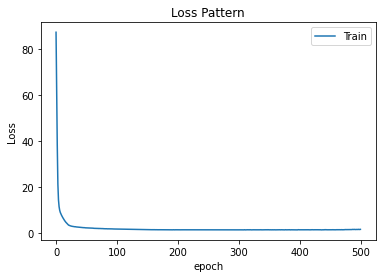

In [12]:
plt.plot(results.history['loss'])
plt.title('Loss Pattern')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()

## Test

In [13]:
X_train_pred = vae_model.predict(X_train_VAE)
error_vector = VariationalAutoencoderModel.get_error_term(X_train_pred, X_train_VAE, _rmse=False)
error_thresh = anomaly_threshold

# Measure the error between the train set and its output and generates an error vector representing the error of each term
# Find an extreme value on the vector to use as the error threshold

/home/andressa.amaral/.local/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [14]:
test_start = time.time()

X_pred_VAE = vae_model.predict(X_test_VAE)

test_end = time.time()
test_time = test_end - test_start
print("Testing time:", test_time)

# If the error of the vector is higher than the defined threshold it detects an attack

error_vector = VariationalAutoencoderModel.get_error_term(X_pred_VAE, X_test_VAE, _rmse=False)
attacks = (error_vector > error_thresh)
print(attacks)

np.count_nonzero(attacks) / len(attacks) # Percentage of attacks

Testing time: 28.100983142852783
[ True False False ...  True  True  True]


0.9939306486119092

In [15]:
print(len(X_test_VAE))

837157


## Metrics

In [16]:
sys.stdout = open("Results/S1003_camera.txt", "a")

print(" ==== Test " + str(number_features) + " Normal learning rate ====")
print("Training time:" + str(train_time))
print("Testing time:" + str(test_time))
print(classification_report(Y_test_VAE, attacks, digits = 5))

In [17]:
'''# Examinig the latent space generated by the encoder

X_encoded = encoder.predict(X_test_VAE)

pca = PCA(n_components=2)
X_analysis = pca.fit_transform(X_encoded)'''

'# Examinig the latent space generated by the encoder\n\nX_encoded = encoder.predict(X_test_VAE)\n\npca = PCA(n_components=2)\nX_analysis = pca.fit_transform(X_encoded)'

In [18]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)
plt.grid()
plt.show()

# Darker clusters indicate that the error is higher'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)\nplt.grid()\nplt.show()\n\n# Darker clusters indicate that the error is higher'

In [19]:
'''plt.figure(figsize=(12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)
plt.grid()
plt.show()

# Orange ones are anomalies'''

'plt.figure(figsize=(12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)\nplt.grid()\nplt.show()\n\n# Orange ones are anomalies'

In [20]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)
plt.grid()
plt.show()

# Ground truth'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)\nplt.grid()\nplt.show()\n\n# Ground truth'